In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import os
import matplotlib as mpl
from PIL import Image
from palettable.cmocean.sequential import Deep_20
deep = mcolors.ListedColormap(Deep_20.mpl_colors)
import glob
from matplotlib import colors
from matplotlib.colors import LogNorm
import metpy.calc as calc
from metpy.units import units
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import TwoSlopeNorm
import h5py
from matplotlib.lines import Line2D

/home/cneumaie/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load in file

In [19]:
style = "/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle"
plt.style.use(style)
plt.rcParams['lines.markersize']= 12
plt.rcParams['font.size'] = 35

Duplicate key in file '/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle', line 15 ("xtick.color: 'k'")
Duplicate key in file '/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle', line 16 ("ytick.color: 'k'")
Duplicate key in file '/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle', line 27 ('axes.edgecolor:222222')


In [20]:
savePath = "./CPTrain_Figs/"

In [21]:
def func1(thv_array,ny, base1edge, base1_r, thv_threshold1,thv_threshold2,
          cp1_start, cp2_start,base1_speed, cp_disp_thresh_n, cp_disp_thresh_s, cp2_r_adj_init_n, cp2_r_adj_init_s,
         initial_flag_n, initial_flag_s):
    '''This is the outer function that takes an array of virtual potential temperatures, selected virtual
    potential temperature thresholds to define the location of the edge of the cold pools, start times to track the
    cold pools, speed to mone the environmental box, number of points to adjust the cold pool boxes for the 
    environment of cold pool 2, and flags to 
    theta-v array: 3d array of theta-v at the lowest model level above ground in nt,ny,nx 
    cp_center: center esitmate of cold pool 
    base1edge: upper boundary to base state for cp1
    base1_r: size of radius for defining base state for cp1
    thv_threshold_1: theta_v threshold used to define edge of cp1
    thv_threshold_2: theta_v threshold used to define edge of cp2
    cp1_start: start index for tracking cp1
    cp2_start: start index for tracking cp2
    returns:
    cp_edges_n
    cp_edges_s
    thv_prime_1
    thv_prime_2
    lower_box_n
    upper_box_n
    lower_box_s
    upper_box_s
    '''

    thv_mean = np.mean(thv_array, axis = 2) ###calculate mean of theta_v through x dimension
    thv_bar1 = np.zeros(len(thv_mean[:,1]))
    base1_edge_array = np.zeros(len(thv_mean[:,0]))
    base1_edge_s_array = np.zeros(len(thv_mean[:,0]))
    base1_edge_s = base1edge-base1_r
    for t in range(len(thv_mean[:,0])):
        if base1edge >= len(thv_mean[0,:]):
            base1edge = base1edge-len(thv_mean[0,:])
        if base1_edge_s >= len(thv_mean[0,:]):
            base1_edge_s = base1_edge_s-len(thv_mean[0,:])
        if base1edge > base1_edge_s:
            thv_bar1[t] = np.mean(thv_mean[t,base1_edge_s:base1edge]) ###calculates base state for cp1
        else:
            thv_bar1[t] = np.mean(np.concatenate((thv_mean[t,base1_edge_s:],thv_mean[t,:base1edge])))
        
        base1_edge_array[t] = np.copy(base1edge)
        base1_edge_s_array[t] = np.copy(base1_edge_s)
        
        base1edge = base1edge + base1_speed
        base1_edge_s = base1_edge_s + base1_speed
    
    nicks_offset_n = np.copy(base1_edge_s_array)
    nicks_offset_s = np.copy(base1_edge_array)
    nicks_offset_n[nicks_offset_n<1500] = 0
    nicks_offset_n = ny-1-nicks_offset_n
    nicks_offset_s[nicks_offset_s>1500] = 0
    thv_mean_n = thv_mean[:,:] ###splits mean into n and s components relative t cp center
    thv_mean_s = thv_mean[:,:]
    thv_mean_s = np.flip(thv_mean_s, axis =1) ### flips s to be have increasing indicies relative to cp center
    cp_edges_n, thv_prime_1n, thv_prime_2n, lower_box_n, upper_box_n, cp2_min_ind_n= func2(thv_mean_n,thv_bar1, thv_threshold1,
                 thv_threshold2, cp1_start, cp2_start, cp_disp_thresh_n, cp2_r_adj_init_n,initial_flag_n,nicks_offset_n)
    cp_edges_s,thv_prime_1s, thv_prime_2s, lower_box_s, upper_box_s, cp2_min_ind_s = func2(thv_mean_s, thv_bar1, thv_threshold1,
                 thv_threshold2, cp1_start, cp2_start, cp_disp_thresh_s, cp2_r_adj_init_s, initial_flag_s,nicks_offset_s)
    

    cp_edges_s = ny-1-cp_edges_s ### flips the dimensions of southern edge to get it back to same indicies of original array
    lower_box_s = ny-1-lower_box_s
    cp2_min_ind_s = ny-1-cp2_min_ind_s

    thv_prime_1 = np.concatenate((np.flip(thv_prime_1s, axis =1),thv_prime_1n), axis =1)
    thv_prime_2 = np.concatenate((np.flip(thv_prime_2s, axis =1),thv_prime_2n), axis =1) 
    
    #
    ns_merge_thresh = 5#10 
    ns_merge_thresh2 = 50#60#40#20 
    ss_merge_thresh = 20 ### buffer for initial ss mergers
    if(cp_edges_s[cp2_start-2,0]>cp_edges_n[cp2_start,1]):
        cp_edges_s[:,2] = np.NaN   ###could not merge with south
        thv_prime_1 = thv_mean-thv_bar1[:,None]
        nt = len(thv_prime_1[:,0])
        cp_edges_s[cp2_start-1,0] = np.NaN
        for t in range(cp2_start-1,nt):
            if t== cp2_start-1:
                temp_cp1_edge = np.argmax(thv_prime_1[t,int(cp_edges_n[t+1,1]+ns_merge_thresh):] < thv_threshold1)
                temp_cp1_edge = temp_cp1_edge + int(cp_edges_n[t+1,1]+ns_merge_thresh)
            else:
                ### Do the next two lines (commented out) ever really do anything?
                # if(np.isnan(cp_edges_n[t,1])):
                #     break
                temp_cp1_edge = np.argmax(thv_prime_1[t,int(cp_edges_n[t,1]+ns_merge_thresh):] < thv_threshold1)
                ###This might not be conservative enough, look at later
                if(temp_cp1_edge==0):
                    cp_edges_s[t:,0] = np.NaN
                    if(cp_edges_s[t-1,0]<(cp_edges_n[t,1]+ns_merge_thresh2)):
                        cp_edges_n[t:,2] = np.copy(cp_edges_n[t:,1])
                        break
                    ### This kinda gets some of the later n-s mergers, but
                    ### is often a few time output off
                    # for t2 in range(t,nt):
                        # cp1_mean_speed = (cp_edges_s[t-1,0]-cp_edges_s[t-1-5,0])/5
                        # if(cp_edges_n[t2,1]>(cp_edges_s[t-1,0]+cp1_mean_speed*(t2-(t-1)))):
                        #     cp_edges_n[t2:,2] = np.copy(cp_edges_n[t2:,1])
                        #     break 
                    break
                temp_cp1_edge = temp_cp1_edge + int(cp_edges_n[t,1]+ns_merge_thresh)
                
            cp_edges_s[t,0] = temp_cp1_edge
    elif(cp_edges_s[cp2_start-2,0]>cp_edges_s[cp2_start,1]+ss_merge_thresh):
        cp_edges_n[cp2_start:,2]= np.copy(cp_edges_n[cp2_start:,1])
        cp_edges_s[:,2] = np.NaN
        cp_edges_s[cp2_start-1:,0]= np.NaN
        
    return cp_edges_n, cp_edges_s, thv_prime_1, thv_prime_2, lower_box_n, upper_box_n, lower_box_s, upper_box_s,  base1_edge_array, base1_edge_s_array, cp2_min_ind_n, cp2_min_ind_s
    

In [22]:
def func2(thv_mean,thv_bar_1, thv_threshold1,thv_threshold2, cp1_start, cp2_start, cp_disp_thresh, cp2_r_adj_init,initial_flag,baseedge):
    
    thv_prime_1 = thv_mean-thv_bar_1[:,None] ###calculates theta-v pertubation for cp1 relative to the base state 1
    ny = np.size(thv_prime_1[0,:])
    nt = len(thv_prime_1[:,0])
    cp1_edges = np.zeros(nt)
    cp1_edges[:] = np.NaN
    
    
    for t in range(cp1_start,nt):
        nicks_offset = int(baseedge[t])
        temp_cp1_edge = ny-1-nicks_offset-np.argmax(np.flip(thv_prime_1[t,:ny-nicks_offset]) < thv_threshold1)   ###generates a point (y) for cp1_edge based on the maximum location where threshold is reached
        if(temp_cp1_edge==(ny-1-nicks_offset)):
            cp1_edges[t:] = np.NaN
            break
        #?
        cp1_edges[t] = temp_cp1_edge
        ### this could use more work for dissapating cold pool 1 threshold, behaves more asymmetrically than we like
        ### maybe different thresholds for upshear vs downshear vs no wind
        if(cp1_edges[t]<(cp1_edges[t-1]-cp_disp_thresh)): #adding the -30 made things a lot better!
            cp1_edges[t:] = np.NaN
            
            break
        
    cp1_edges_int = np.round(cp1_edges).astype(int)   
    cp2_min_ind = np.zeros(nt)
    cp2_min_ind[:] = np.nan
    ###calculates an initial base state at the last time where only cp1 is present, 
    base_state2 = np.min(thv_mean[cp2_start-2,:])                                                                           ###it is the mean of the inside of cp1 at this time (for half being calculated)
    cp2_min_ind[cp2_start+1] = np.argmin(thv_mean[cp2_start-2,:])
    thv_bar2 = np.zeros(nt)
    thv_prime_2 = np.zeros((nt,ny))
    cp2_edges = np.zeros(nt)
    cp2_edges[:] = np.nan
    cp_merged_edges = np.zeros(nt)
    cp_merged_edges[:] = np.nan
    upper_box = np.zeros(nt)
    upper_box[:] = np.nan
    lower_box = np.zeros(nt)
    lower_box[:] = np.nan

    for t in range(cp2_start,nt):
        if t == cp2_start or t == cp2_start+1:
            thv_bar2[t] = base_state2  ##calculates base state from before cold pool 2 for these 2 timesteps
        else:
            if(np.isnan(cp1_edges[t])):
                thv_bar2[t] = np.min(thv_mean[t,int(lower_box[t]):])#thv_bar2[t] = thv_bar_1[t]
                cp2_min_ind[t] = np.argmin(thv_mean[t,int(lower_box[t]):])+lower_box[t]

            else:
                thv_bar2[t] = np.min(thv_mean[t,int(lower_box[t]):])   ###calculates base state between edge of cp1 and radius base2_r
                cp2_min_ind[t] = np.argmin(thv_mean[t,int(lower_box[t]):]) +lower_box[t]
    
        thv_prime_2[t] = thv_mean[t,:]-thv_bar2[t]
        temp_cp2_edge = ny-1-np.argmax(np.flip(thv_prime_2[t,:]) < thv_threshold2)
        
        if temp_cp2_edge == ny-1:
            cp2_edges[t:] = np.nan
            break
        cp2_edges[t] = temp_cp2_edge
         #check to see if the cold pool is still propagating forward, if it is not, th
        if(cp2_edges[t]<(cp2_edges[t-1]-cp_disp_thresh)):
            cp2_edges[t:] = np.NaN
            break
                
        # cp2_r_adj_init = 60#30#60   ### The first radius bump in gridpoints for the initial radius guess for the cp2_start+1 time   
        if t == cp2_start+1:
            lower_box[t] = cp2_edges[t]+cp2_r_adj_init
        
        if t > cp2_start and t<nt-1: #nt-2?
            ### Setting an initial guess for the future radius of the base state for cp2
            lower_box[t+1] = lower_box[t]+(cp2_edges[t]-cp2_edges[t-1])#-(cp1_edges[t]-cp1_edges[t-1])
        max_dist_from_cp1= 20 ###this is the minimum number of gridpoints that can be between cp1 edge and cp2 edge        
       ###if cp2_edge is greater than or equal to the minimum # of gridpoints between cp2 edges, they are considered merged
        if(cp2_edges[t]>=(cp1_edges_int[t]-max_dist_from_cp1)):
            # cp2_edges[t+1:] = np.nan
            cp_merged_edges[t+1:] = np.copy(cp1_edges[t+1:])
            cp2_edges[t+1:]= np.copy(cp1_edges[t+1:]) ##this is changed
            cp1_edges[t+1:] = np.nan
            break   #break cp2 loop if the cps have merged
            
        #?
        s_shear_init_merge_thresh = 125
        if initial_flag == True:  ###for south side when  sheared
            if(t==cp2_start):
                if(cp2_edges[t]>=(cp1_edges_int[t]-s_shear_init_merge_thresh)): 
                    cp_merged_edges[t+1:] = np.copy(cp1_edges[t+1:])
                    cp2_edges[t+1:]= np.copy(cp1_edges[t+1:]) ##this is changed
                    cp1_edges[t+1:] = np.nan
                    break
        #?
    cp_edges = np.zeros((nt,4))
    cp_edges[:,0] = cp1_edges
    cp_edges[:,1] = cp2_edges
    cp_edges[:,2] = cp_merged_edges
    times = np.arange(len(cp_edges))*5
    cp_edges[:,3] = times
    
    return cp_edges, thv_prime_1, thv_prime_2, lower_box, upper_box, cp2_min_ind
    

In [23]:
def make_cpfile(filePath, cp_edges_n, cp_edges_s, lower_box_n, upper_box_n, lower_box_s, upper_box_s, base1_edge_array, base1_edge_s_array
               ,base1_edge, base1_r, cp2_min_ind_n, cp2_min_ind_s):
    temp_list = [5,10,20]
    time_list = [30,60,90, 120]
    wind_list = ['shear', 'u0']
    ###extra dimensions for above + n vs s
    for wind in wind_list:
        for CP1_temp in temp_list:
            for CP2_temp in temp_list:
                for time in time_list:
                    if f"CP1_{CP1_temp}k_CP2_{CP2_temp}k_{time}min_{wind}" in filePath:
                        outfilename = f"./cpfile_edges_v7/cpfile_CP1_{CP1_temp}k_CP2_{CP2_temp}k_{time:03}min_{wind}_v2.h5"
                        test_dataset = h5py.File(outfilename, 'w')
                        test_dataset.create_dataset('cp_edges_n', data=cp_edges_n)
                        test_dataset.create_dataset('cp_edges_s', data=cp_edges_s)
                        test_dataset.create_dataset('lower_box_n', data=lower_box_n)
                        test_dataset.create_dataset('lower_box_s', data=lower_box_s)
                        test_dataset.create_dataset('base1_edge_array_n', data=base1_edge_array)
                        test_dataset.create_dataset('base1_edge_array_s', data=base1_edge_s_array)
                        test_dataset.create_dataset('cp2_min_ind_n', data= cp2_min_ind_n)
                        test_dataset.create_dataset('cp2_min_ind_s', data= cp2_min_ind_s)
                        test_dataset.close()

In [27]:
def func3(outfilename, base1edge, base1_r):
    
    if "30min" in outfilename:
        cp2_start = 8
    elif "60min" in outfilename:
        cp2_start = 14
    elif "90min" in outfilename:
        cp2_start = 20
    elif "120min" in outfilename:
        cp2_start = 26 
    if "shear" in outfilename:
        base1_speed = 33 #10   ###number of gridpoints to move base state for cp1 per time output
        base1edge = 2050#2800
        ###the number of gridpoints that the edge of the cold pool is allowed to travel backwards between timesteps to see if it is still propagating
        
        cp_disp_thresh_n = 0   
        cp_disp_thresh_s = 66
        cp2_r_adj_init_n = 60
        cp2_r_adj_init_s = 60#30#60
        initial_flag_n = False
        initial_flag_s = True
    else:
        base1_speed = 0
        cp_disp_thresh_n = cp_disp_thresh_s = 33
        cp2_r_adj_init_n = cp2_r_adj_init_s = 30
        initial_flag_n = initial_flag_s = False
        
    test_dataset = h5py.File(outfilename, 'r')
    thv = np.array(test_dataset['thv'])
    test_dataset.close()
    
    thv_threshold1 = -0.5#-0.5#-0.5#-0.3
    if "30min" in outfilename:
        thv_threshold2 = -0.3#-0.3#-0.4#-0.75#-1.0#-2.25#-1.5
    else:
        thv_threshold2 = -0.3
    cp_center = 1050
    ny = np.size(thv[0,:,0])
    cp1_start = 2
    speed_time_avg = 12
  
    #
    cp_edges_n, cp_edges_s, thv_prime_1, thv_prime_2, lower_box_n, upper_box_n, lower_box_s, upper_box_s, base1_edge_array, base1_edge_s_array, cp2_min_ind_n, cp2_min_ind_s = func1(thv,ny, base1edge, base1_r, thv_threshold1,
                 thv_threshold2, cp1_start, cp2_start,base1_speed, cp_disp_thresh_n, cp_disp_thresh_s, cp2_r_adj_init_n, cp2_r_adj_init_s, initial_flag_n, initial_flag_s)
    thv_mean = np.mean(thv, axis = 2)  
    
    print(outfilename)

    if "shear" in outfilename:
        suptitle = "SHEAR"
        title1 = "d)"
        title2 = "e)"
        title3 = "f)"
    else:
        suptitle = "NOWIND"
        title1 = "a) Step 1: \n Split domain by CP center"
        title2 = "b) Step 2: \n Define CP1 envir. and edge"
        title3 = "c) Step 3: \n Define CP2 envir. and edge"
    plt.subplots(nrows = 1, ncols = 3, figsize = (35,10))
    ax1 = plt.subplot(131)
    ### Start plot here
    c = plt.pcolormesh(np.transpose(thv_mean)) 

    plt.axhline(y=1050, color='r', linestyle='--')
    nt = len(thv_mean[:,1])
    plt.xlabel("time (min)")
    plt.xticks(np.arange(0,nt+1,5), np.arange(0,nt+1,5)*5)
    plt.yticks(np.arange(0,len(thv_mean[0,:])+1,500), np.arange(0,len(thv_mean[0,:])+1,500)/10)
    plt.title(title1, loc = "left")
    plt.ylabel("y (km)")
    ### end plot here
    ax2 = plt.subplot(132)
    ### Start plot here
    c = plt.pcolormesh(np.transpose(thv_mean))
    nt = len(thv_mean[:,1])
    ny = len(thv_mean[0,:])
    plt.scatter(np.arange(nt), cp_edges_n[:,0],color='orange')

    plt.scatter(np.arange(nt), base1_edge_array[:],color='C0')
    plt.scatter(np.arange(nt), base1_edge_s_array[:],color='C1')

    plt.xlabel("time (min)")
    plt.xticks(np.arange(0,nt+1,5), np.arange(0,nt+1,5)*5)
    plt.yticks(np.arange(0,ny+1,500), np.arange(0,ny+1,500)/10)
    plt.title(title2, loc = "left")
    plt.ylim(1050,ny)

    ### end plot here
    ax3 = plt.subplot(133)
    ### Start plot here
    c = plt.pcolormesh(np.transpose(thv_mean)) #vmin = -2, vmax =2 , cmap = 'bwr')
    plt.colorbar(c, label = r"$\Theta$$_v$ (K)")
    nt = len(thv_mean[:,1])
    ny = len(thv_mean[0,:])
    plt.scatter(np.arange(nt), cp_edges_n[:,0],color='orange')
    if "shear" in outfilename:
        plt.scatter(np.arange(16,nt),cp2_min_ind_n[16:], color = 'C5')
    else:
        plt.scatter(np.arange(nt),cp2_min_ind_n[:], color = 'C5')
    plt.scatter(np.arange(nt), cp_edges_n[:,1], color = 'pink')
    plt.scatter(np.arange(nt), cp_edges_n[:,2], color = 'C9')
    plt.xlabel("time (min)")
    plt.xticks(np.arange(0,nt+1,5), np.arange(0,nt+1,5)*5)
    plt.yticks(np.arange(0,ny+1,500), np.arange(0,ny+1,500)/10)
    plt.title(title3, loc = "left")
    plt.ylim(1050,ny)
    plt.suptitle(suptitle, weight = "bold", y=0.95, fontsize = 50)
    plt.savefig(savePath+suptitle+"tracking_v2")
    plt.show()
    plt.close()
    ### end plot here



In [28]:
filePaths = ["./thv_CP1_20k_CP2_20k_60min_u0_1.h5",  "./thv_CP1_20k_CP2_20k_60min_shear_1.h5"]


/tmp/ipykernel_671361/1308399899.py:25: RuntimeWarning: invalid value encountered in cast
  cp1_edges_int = np.round(cp1_edges).astype(int)


./thv_CP1_20k_CP2_20k_60min_u0_1.h5


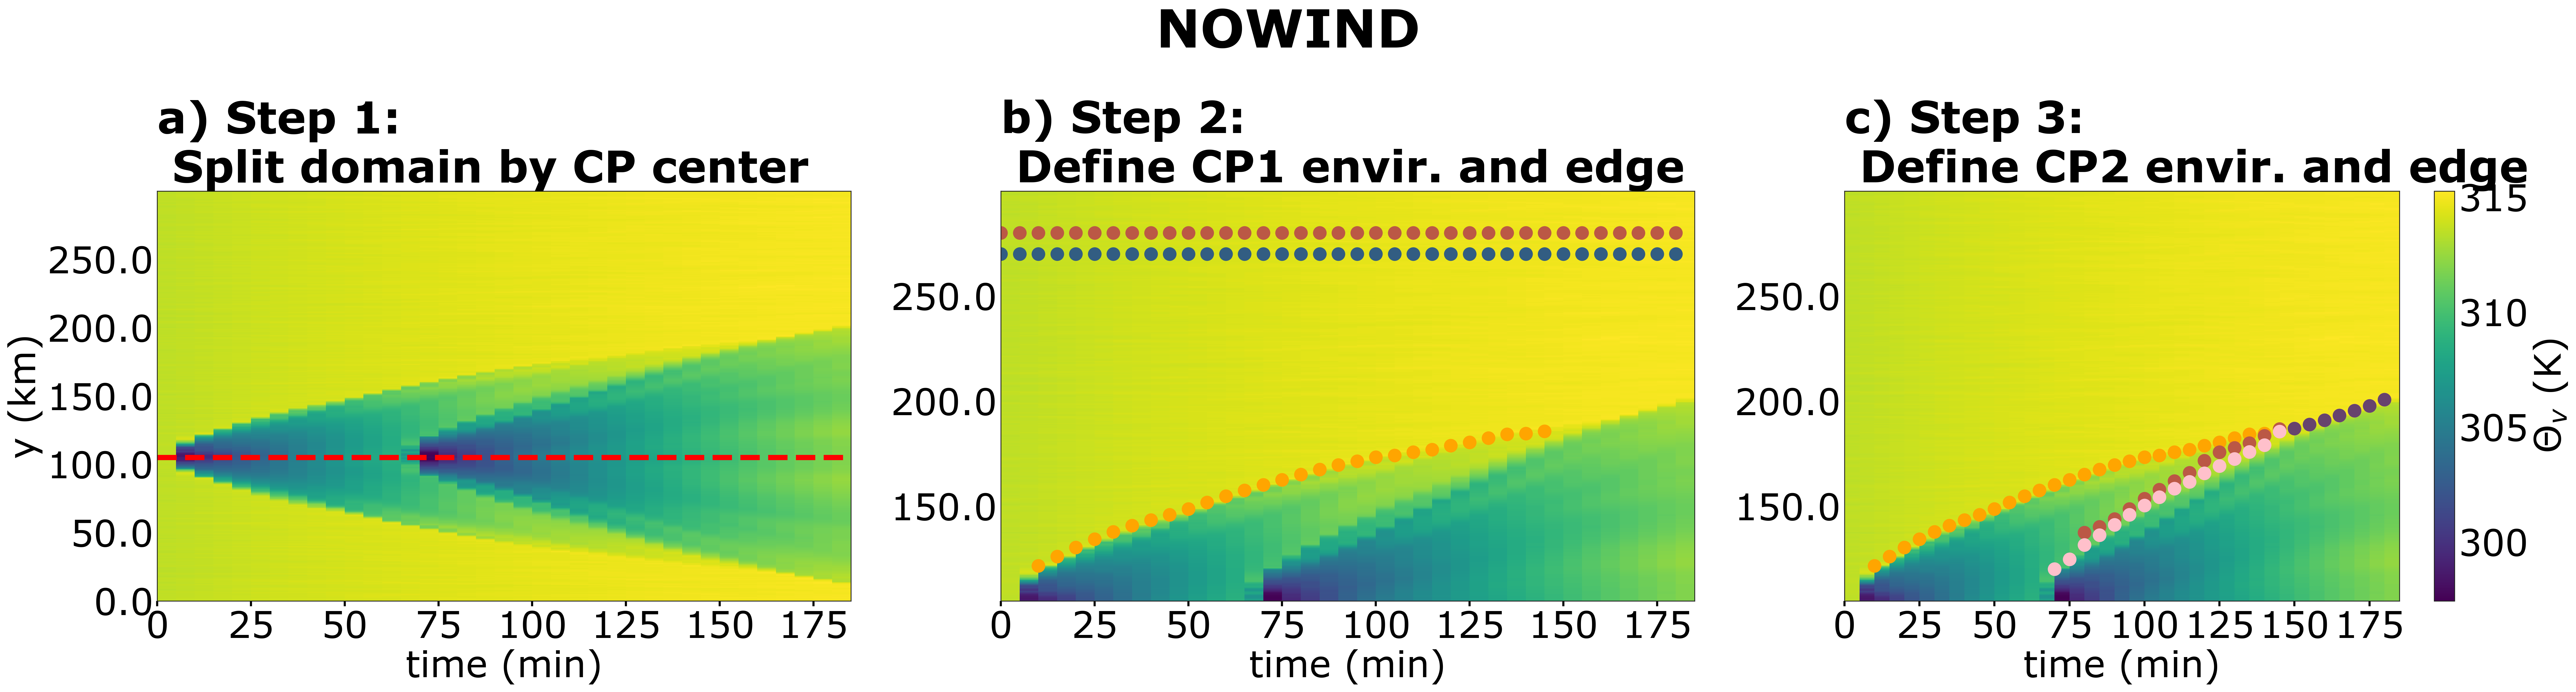

/tmp/ipykernel_671361/1308399899.py:25: RuntimeWarning: invalid value encountered in cast
  cp1_edges_int = np.round(cp1_edges).astype(int)
/tmp/ipykernel_671361/1308399899.py:75: RuntimeWarning: overflow encountered in scalar subtract
  if(cp2_edges[t]>=(cp1_edges_int[t]-max_dist_from_cp1)):


./thv_CP1_20k_CP2_20k_60min_shear_1.h5


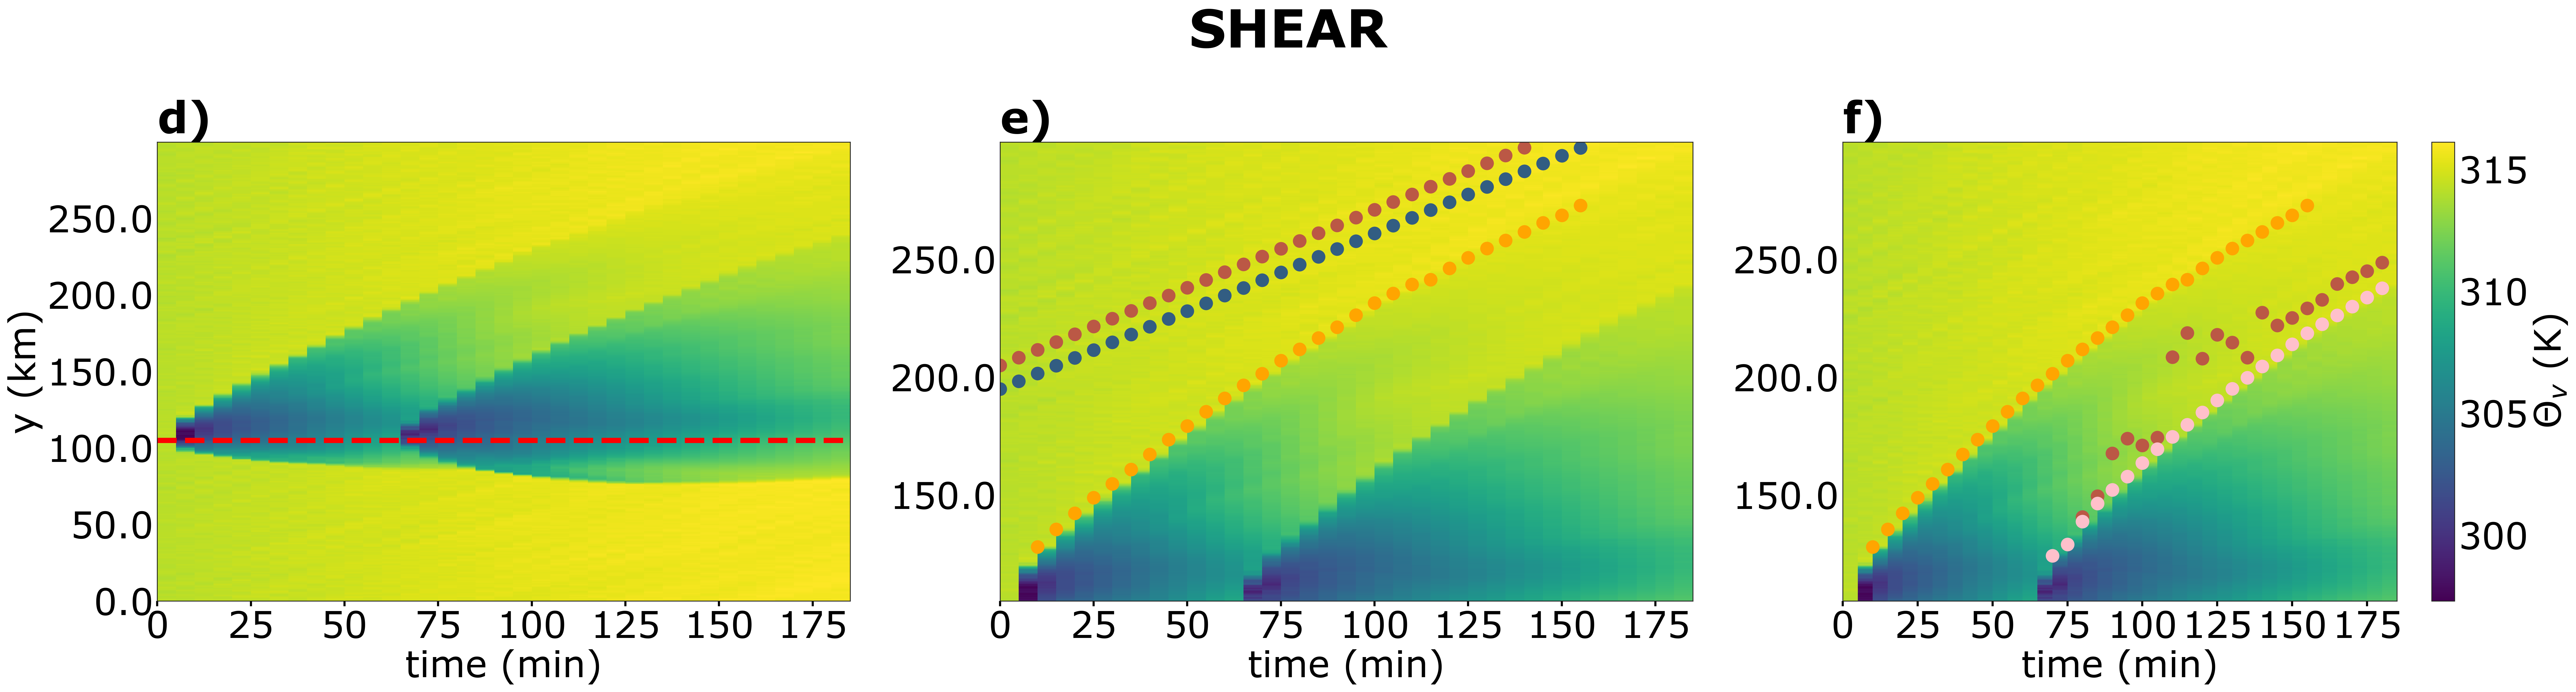

In [29]:
base1_edges_list = np.arange(2800,2801,1)
b = 2800
base1_r_list = np.arange(60,61,1)
r = 100
for filePath in filePaths:
    func3(filePath,b,r)